### AI2100/AI5100 - Deep Learning
### Assignment 2


In [67]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# reads image from a particular path
def read_image(path):
    image = plt.imread(path)
    return image

# displays images
def display_image(image, size = 4, title = None):
    aspect_ratio = image.shape[1]/image.shape[0]
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

#normalizes images
def normalize(image):
    return ((image - np.min(image))/(np.max(image) - np.min(image)))

In [69]:
image = read_image('iith_logo.png')
normalized_image = normalize(image)

1. **Convolution function**: It accepts an image input, a filter kernel, stride, padding, and the non-linear function. The function must convolve the input image (after padding if specified) with the kernel (at the specified stride size) and generate an output activation after applying the specified non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid, tanh, ReLU, Leaky ReLU. Display the input image (e.g. a small image of the IITH logo), the filter kernel, and the output activation map. Ensure that your function can accept multi-channel input and a corresponding kernel volume. (5)

In [70]:
# activation functions:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def leakyRelu(x):
    return np.maximum(0.01 * x, x)

In [71]:
# different kernels used
outline = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])
kernel1 = np.array([outline, outline, outline, outline])

edges = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])
kernel2 = np.array([edges, edges, edges, edges])

activation_choices = [sigmoid, tanh, relu, leakyRelu]

In [72]:
def conv(image, kernel, stride = [1, 1], padding = [0, 0], activation = None):
    # dimension of image = W x H x C
    # dimension of kernel = C x w x h

    if (image.ndim == 2):
        image = image[:, :, np.newaxis]
    
    if (kernel.ndim == 2):
        kernel = kernel[np.newaxis, :, :]
    
    # checking if dimensions of image and kernel matches
    if (image.shape[2] != kernel.shape[0]):
        print ("Convolution cannot be done")
        return
        
    # padding image
    if (padding[0] != 0 or padding[1] != 0):
        padded_image = np.zeros((image.shape[0] + 2*padding[0], image.shape[1] + 2*padding[1], image.shape[2]))

        padded_image[padding[0]:-padding[0], padding[1]:-padding[1], :] = image
        image = padded_image
    
    output = np.zeros(((image.shape[0] - kernel.shape[1])//stride[0] + 1, (image.shape[1] - kernel.shape[2])//stride[1] + 1), dtype = np.int32)

    for k in range(image.shape[2]):
        for i in range(0, output.shape[0]):
            for j in range(0, output.shape[1]):
                new_i = i * stride[0]
                new_j = j * stride[1]
                image_region = image[new_i:new_i + kernel.shape[1], new_j: new_j + kernel.shape[2], k]
                output[i][j] += np.sum(np.multiply(image_region, kernel[k, :, :]))

    # apply activation
    if (activation):
        output = activation(output)
        
    return output

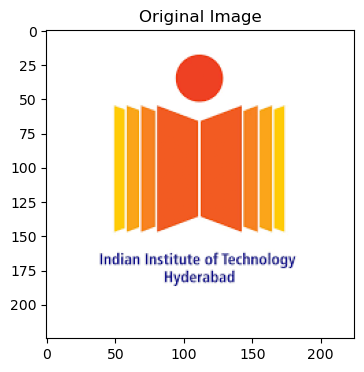

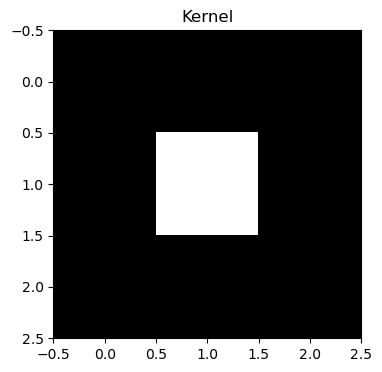

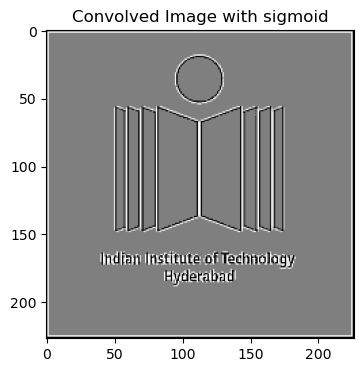

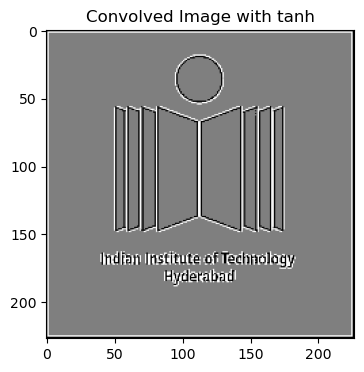

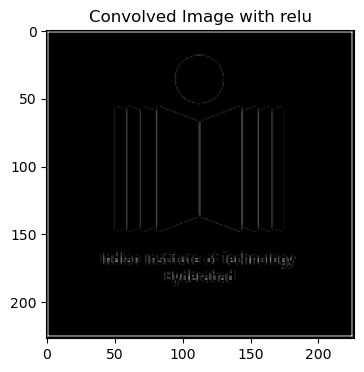

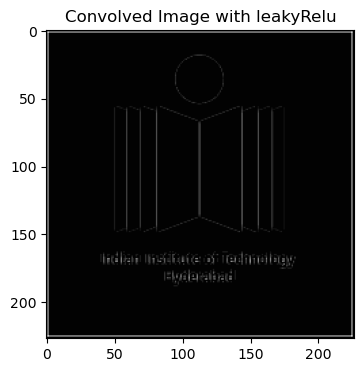

In [102]:
display_image(normalized_image, title = "Original Image")
display_image(outline, title = "Kernel")

for activation in activation_choices:
    convolved_image = conv(normalized_image, kernel1, stride=[1,1], padding = [2, 2], activation=activation)
    display_image(convolved_image, title = f"Convolved Image with {activation.__name__}")

2. **Pooling function**: It accepts as input the activation map output from the convolution function,
a pooling function, and stride. The function must output the appropriately pooled activation map.
Display the input activation map and the pooled output.

In [74]:
# pooling functions:

def maxPool(matrix):
    return matrix.max()

def avgPool(matrix):
    return np.sum(matrix)/(matrix.shape[0] * matrix.shape[1])

In [75]:
def pooling(activation_map, pool_func, stride = [1, 1], window_size = [2, 2]):
    # dim of activation map: W x H x C
    
    if activation_map.ndim == 2:
        activation_map = activation_map[:, :, np.newaxis]
    
    output = np.zeros(((activation_map.shape[0] - window_size[0])// stride[0] + 1, (activation_map.shape[1] - window_size[1])// stride[1] + 1, activation_map.shape[2]))

    for k in range (activation_map.shape[2]):
        for i in range (output.shape[0]):
            for j in range (output.shape[1]):
                new_i = i * stride[0]
                new_j = j  * stride[1]
                region = activation_map[new_i:new_i + window_size[0], new_j: new_j + window_size[1], k]
                output[i][j][k] = pool_func(region)
    
    return output

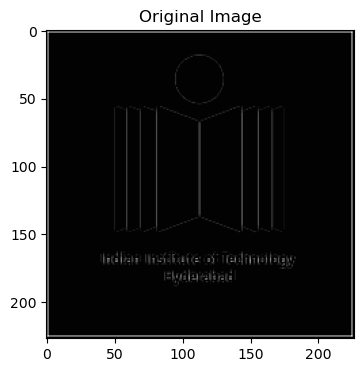

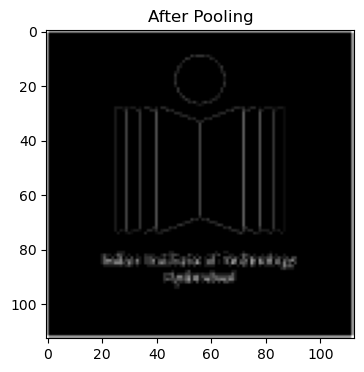

In [76]:
display_image(convolved_image, title = "Original Image")
pooled_image = pooling(convolved_image, maxPool, stride = [2, 2])
display_image(pooled_image, title = "After Pooling")

3. **Convolution layer function**: It accepts as input a volume (image or activation maps), number
of filters, kernel dimensions, stride, padding, and the non-linear activation function. The function
must convolve the input volume (after padding if specified) with each kernel (at the specified stride
size) and generate an output activation volume after applying the specified non-linearity. Display
the input image or activation maps, the filter kernels, and the output activation maps. Verify that
the output of this function does indeed have the expected size (W × H × C) as discussed in class.

In [77]:
def conv_layer(input, kernel, no_kernels, stride = [1, 1], padding = [0, 0], activation = None):

    # kernel shape: N x C x h x w
    # input shape: H x W x C
    
    output = np.zeros(((input.shape[0] + 2 * padding[0] - kernel.shape[2])//stride[0] + 1, (input.shape[1] + 2 * padding[1] - kernel.shape[3])//stride[1] + 1, no_kernels))
    
    # performs conv function for different kernels
    for i in range(no_kernels):
        output[:, :, i] = conv(input, kernel[i, :, :, :], stride, padding, activation)
    
    return output

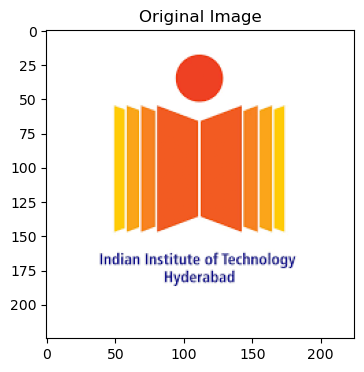

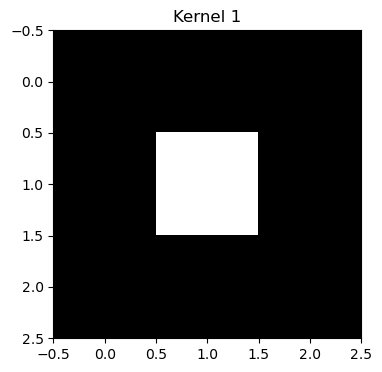

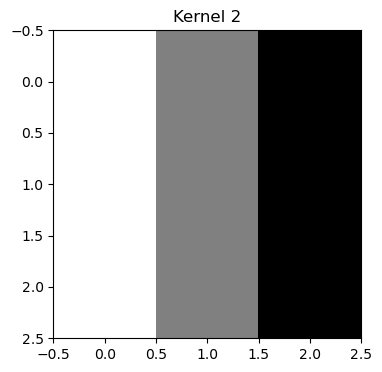

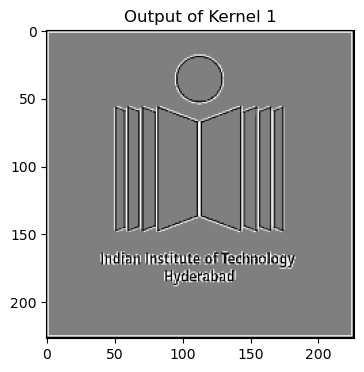

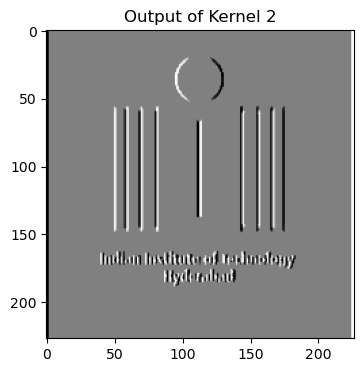

In [99]:
display_image(normalized_image, title = "Original Image")

kernel_used = np.array([kernel1, kernel2])
for i, kernel in enumerate(kernel_used):
    display_image(kernel[0], title = f"Kernel {i + 1}")

conv_layer_output = conv_layer(normalized_image, kernel_used, 2, stride = [1, 1], padding = [2, 2], activation = sigmoid)

for i in range(conv_layer_output.shape[2]):
    display_image(conv_layer_output[:, :, i], title = f"Output of Kernel {i + 1}")

In [79]:
print(image.shape)
print(np.array([kernel1, kernel2]).shape)
print(conv_layer_output.shape)

(225, 225, 4)
(2, 4, 3, 3)
(227, 227, 2)


Clearly, the shape of the output is as expected. <br/>
Number of channels in output is number of kernels. <br/><br/>
Width of output = $\frac{W - w + 2p}{s} + 1$ = $\frac{225 - 3 + 4}{1} + 1$ = 227 <br/><br/>
Height of output = $\frac{H - h + 2p}{s} + 1$ = $\frac{225 - 3 + 4}{1} + 1$ = 227 <br/>

4. **Pooling layer function**: It accepts as input the activation map volume, the pooling function,
stride, and generates a pooled output volume. A special case for performing Global Average Pooling
should also be provided.

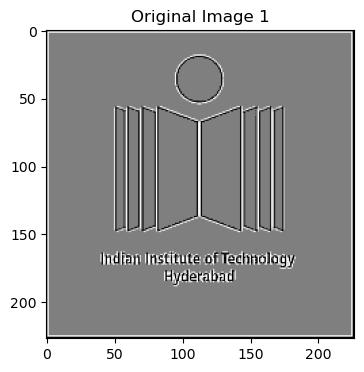

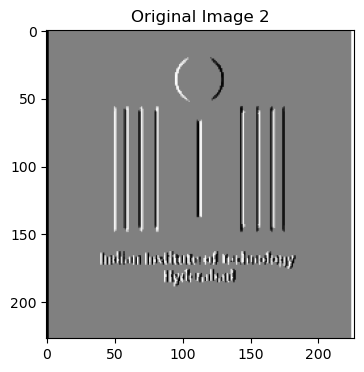

(113, 113, 2)


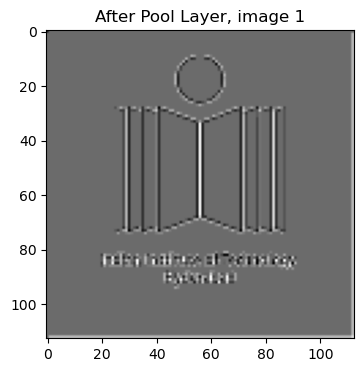

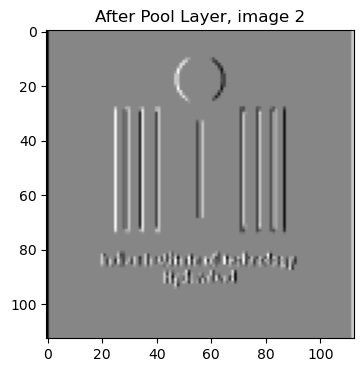

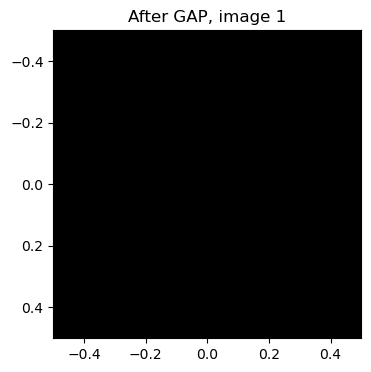

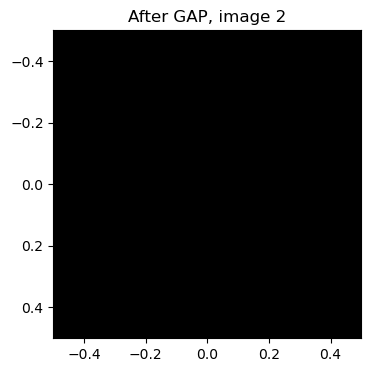

In [80]:
def pool_layer(input, pool_func = maxPool, stride = [1, 1], window_size = [2, 2], gap = False):
    # input.shape = W x H x N
    if gap:
        window_size = [input.shape[0], input.shape[1]]
        pool_func = avgPool
    return pooling(input, pool_func, stride, window_size)

pool_layer_output = pool_layer (conv_layer_output, avgPool, stride = [2, 2], window_size = [2, 2], gap = False)

# displaying image
for i in range(conv_layer_output.shape[2]):
    display_image(conv_layer_output[:, :, i], title = f"Original Image {i + 1}")
print(pool_layer_output.shape)

# displaying image after pooling
for i in range(pool_layer_output.shape[2]):
    display_image(pool_layer_output[:, :, i], title = f"After Pool Layer, image {i + 1}")

gap_output = pool_layer(conv_layer_output, gap = True)

# displaying image after GAP
for i in range(gap_output.shape[2]):
    display_image(gap_output[:, :, i], title = f"After GAP, image {i + 1}")

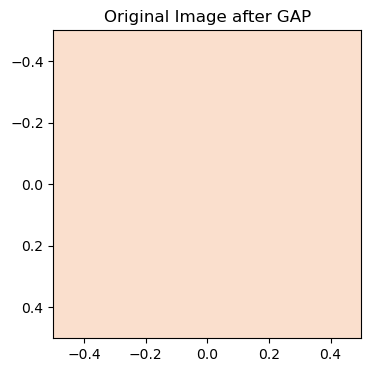

In [81]:
gap_output_orig_image = pool_layer(image, gap = True)
display_image(gap_output_orig_image, title = "Original Image after GAP")

5. **Multilayer Perceptron (MLP) function**: It accepts as input a vector, the number of hidden
layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This
function should generate an output vector of the specified size. Generate the output with and
without the softmax function applied to the output layer. (3)

In [82]:
def softmax(x):
    return (np.exp(x - np.max(x)))/np.sum(np.exp(x - np.max(x)))

In [83]:
def MultiLayerPerceptron(input, no_hidden_layers, hidden_dims, output_dim, activation = sigmoid, isSoftmax = False):
    layer_dims = [input.shape[0]] + hidden_dims + [output_dim]

    output = input

    for i in range(no_hidden_layers + 1):
        temp = np.random.randint(0, 3, size = (layer_dims[i + 1], layer_dims[i]))
        if (i != no_hidden_layers):
            output = activation(temp.dot(output))
        else:
            output = temp.dot(output)

    if (isSoftmax):
        output = softmax(output)

    return output

np.random.seed(42)
input = np.random.randint(0, 3, size = 3)
print("With softmax:", MultiLayerPerceptron(input, 2, [1, 2], 5, isSoftmax = True))
print("Without softmax:", MultiLayerPerceptron(input, 2, [1, 2], 5))

With softmax: [0.40466349 0.40466349 0.07004371 0.03929402 0.08133529]
Without softmax: [0.5        0.         2.41397474 1.70698737 1.70698737]


6. ***Putting-it all together***: Finally, use the functions you have written to implement a CNN with the
following architecture. The CNN must accept an image input and output a vector of appropriate
dimension. In other words, the function must effectively implement the feed-forward path in a
CNN. <br/><br/>
    • Input image of size 224×224×3. Use validation images (or, random crops) from the ILSVRC
    dataset.<br/>
    • Convolution layer with 16 kernels of size 5 × 5 spatial dimensions and ReLU activation.<br/>
    • Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.<br/>
    • Convolution layer with 32 kernels of spatial size 3 × 3 and sigmoid activation.<br/>
    • Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.<br/>
    • A Global Average Pooling (GAP) layer.<br/>
    • An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s
    output and maps it to 1000 output nodes. Use ReLU activation for the MLP (softmax in the
    o/p layer).<br/><br/>
Verify that your composition of function accepts and image input and outputs a vector.

In [84]:
def CNN (input):
    kernel1 = np.random.uniform(0, 1, (16, 3, 5, 5))
    kernel2 = np.random.uniform(0, 1, (32, 16, 3, 3))
    print("Original Image Shape:", input.shape)

    conv1 = conv_layer(input, kernel1, 16, activation = relu)
    print("1st Convolutional Layer:", conv1.shape)
    
    maxpool = pool_layer(conv1, pool_func = maxPool, stride = [2, 2], window_size = [2, 2], gap = False)
    print("Max Pool Layer:", maxpool.shape)
    
    conv2 = conv_layer(maxpool, kernel2, 32, activation = sigmoid)
    print("2nd Convolutional Layer:", conv2.shape)
    
    gap = np.squeeze(pool_layer(conv2, gap = True))
    print("Gap layer:", gap.shape)

    mlp = MultiLayerPerceptron(gap, 1, [gap.shape[0]], 1000, activation = relu, isSoftmax = True) 
    print("MLP layer:", mlp.shape)       
    
    return mlp

In [85]:
image2 = read_image('dataset_image.jpg')

np.random.seed(42)
cnn_output = CNN (normalize(image2))

Original Image Shape: (224, 224, 3)
1st Convolutional Layer: (220, 220, 16)
Max Pool Layer: (110, 110, 16)
2nd Convolutional Layer: (108, 108, 32)
Gap layer: (32,)
MLP layer: (1000,)


Thus, the dimensions after the different layers are correct and the final output is a vector

7. **The adding problem**: In this task, each data sample consists of a sequence of variable length, but a constant depth (size of feature vector at each time instance) of 2. All values of the first dimension (randomly) lie in [0, 1], and the second dimension is all zeros except for two elements that are marked by 1. The objective of the task is to sum the random values whose second dimensions are marked by 1. 

In [86]:
# dataset creation

def create_dataset(max_no = 7, N = 5000):

    dataset = []
    labels = []

    for i in range(N):
        temp = []
        length = np.random.randint(2, max_no)
        for j in range(length):
            temp.append([np.random.random(), 0])

        # setting 2 indices to 1
        index1 = np.random.randint(0, length)
        index2 = np.random.randint(0, length)

        while (index1 == index2):
            index1 = np.random.randint(0, length)
        temp[index1][1] = 1
        temp[index2][1] = 1
        dataset.append(temp)

        sum = 0
        # calculating labels
        for i in range(length):
            sum += temp[i][0] * temp[i][1]
        
        labels.append(sum)
    
    return dataset, labels

dataset, labels = create_dataset(7)

Train the different RNNs (Elman network, LSTM, and GRU) discussed in the class and compare their performance against a baseline that always predicts a sum of 1 plotting the learning curves and final performance. Note that you are expected to implement these models (as opposed to using the built-in constructs).[3 (Elman) + 7 (LSTM) + 4 (GRU)+ 6 (Dataset & baseline & comparison) = 20]

In [87]:
# Elman Network
import torch
import torch.nn as nn

#dataset : N x l x 2

class Elman(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.Wxh = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Whh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Why = nn.Parameter(torch.randn(output_dim, hidden_dim))

        self.bh = nn.Parameter(torch.zeros(hidden_dim, 1))
        self.by = nn.Parameter(torch.zeros(output_dim, 1))

        self._init_weights()
    
    # initialises the weights of the model
    def _init_weights(self):
        nn.init.xavier_uniform_(self.Wxh)
        nn.init.xavier_uniform_(self.Whh)
        nn.init.xavier_uniform_(self.Why)

    # forward pass of model
    def forward(self, inputs):
        # expects input as: [list, list, ...]
        ht = torch.zeros(self.hidden_dim, 1)
        output = torch.zeros(len(inputs))

        for i in range(len(inputs)):
            for input in inputs[i]:
                input = torch.tensor(input)
                input = torch.unsqueeze(input, 1)
                ht = torch.tanh(torch.matmul(self.Wxh, input) + torch.matmul(self.Whh, ht) + self.bh)
            output[i] = torch.matmul(self.Why, ht) + self.by
        return output
    
    # trains model
    def train(self, dataset, labels, epochs, batch_size = 32):

        self.loss = nn.MSELoss(reduction = 'mean')
        loss_list = []
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.01)
        self.optimizer.zero_grad()
        labels = torch.tensor(labels)

        batches = [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]
        actual = [labels[i:i+batch_size] for i in range(0, len(labels), batch_size)]

        for epoch in range(epochs):
            avg_loss = 0
            for i in range(len(batches)):
                pred = self.forward(batches[i])

                calc_loss = self.loss(actual[i], pred)
                avg_loss += calc_loss.item() * len(batches[i])
                calc_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
            loss_list.append(avg_loss/len(dataset))
            print(f"Epoch {epoch}: {avg_loss/len(dataset)}")

        return loss_list

torch.manual_seed(0)
elmanRNN = Elman(2, 7, 1)
loss_elman = elmanRNN.train(dataset, labels, 15)

Epoch 0: 0.3636428910255432
Epoch 1: 0.14488733639717102
Epoch 2: 0.10386167112588883
Epoch 3: 0.08240449466109276
Epoch 4: 0.05747836908102036
Epoch 5: 0.03556416944861412
Epoch 6: 0.02773800039589405
Epoch 7: 0.024291978147625924
Epoch 8: 0.02263160948753357
Epoch 9: 0.021456279295682907
Epoch 10: 0.0204477701485157
Epoch 11: 0.019562389209866523
Epoch 12: 0.01881723040342331
Epoch 13: 0.01820566703081131
Epoch 14: 0.017700873908400534


Incorrect: 832


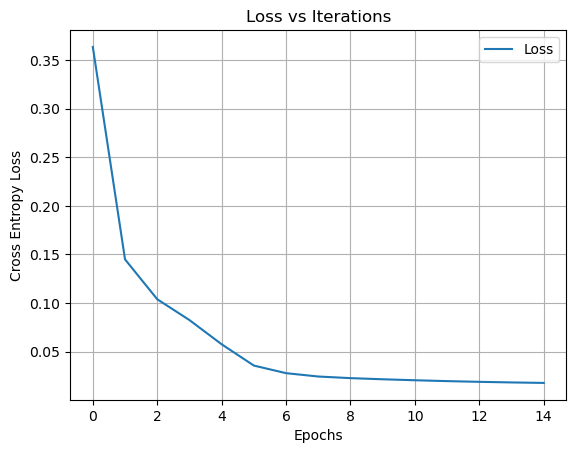

In [88]:
output = elmanRNN.forward(dataset)
incorrect = 0
for i in range(output.shape[0]):
    if (output[i].item() - labels[i] > 0.1):
        incorrect += 1
print("Incorrect:", incorrect)

plt.figure()
plt.plot(loss_elman, label = 'Loss')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid()
plt.show()

In [89]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.Wfh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wfx = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Wih = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wix = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Wch = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wcx = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Woh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wox = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Why = nn.Parameter(torch.randn(output_dim, hidden_dim))

        self.bf = nn.Parameter(torch.zeros(hidden_dim, 1))
        self.bi = nn.Parameter(torch.zeros(hidden_dim, 1))
        self.bc = nn.Parameter(torch.zeros(hidden_dim, 1))
        self.bo = nn.Parameter(torch.zeros(output_dim, 1))
        self.by = nn.Parameter(torch.zeros(output_dim, 1))
        
        self._init_weights()
    
    # initialises the weights of the model
    def _init_weights(self):
        nn.init.xavier_uniform_(self.Wfh)
        nn.init.xavier_uniform_(self.Wfx)
        nn.init.xavier_uniform_(self.Wih)
        nn.init.xavier_uniform_(self.Wix)
        nn.init.xavier_uniform_(self.Wch)
        nn.init.xavier_uniform_(self.Wcx)
        nn.init.xavier_uniform_(self.Woh)
        nn.init.xavier_uniform_(self.Wox)
        nn.init.xavier_uniform_(self.Why)

    # forward pass of model
    def forward(self, inputs):
        # expects input as: [list, list, ...]
        ht = torch.zeros(self.hidden_dim, 1)
        ct = torch.zeros(self.hidden_dim, 1)
        output = torch.zeros(len(inputs))

        for i in range(len(inputs)):
            for input in inputs[i]:
                input = torch.tensor(input)
                input = torch.unsqueeze(input, 1)
                
                ft = torch.sigmoid(torch.matmul(self.Wfh, ht) + torch.matmul(self.Wfx, input) + self.bf)
                it = torch.sigmoid(torch.matmul(self.Wih, ht) + torch.matmul(self.Wix, input) + self.bi)
                ct_temp = torch.tanh(torch.matmul(self.Wch, ht) + torch.matmul(self.Wcx, input) + self.bc)

                ct = torch.mul(ft, ct) + torch.mul(it, ct_temp)

                ot = torch.sigmoid(torch.matmul(self.Woh, ht) + torch.matmul(self.Wox, input) + self.bo)

                ht = torch.mul(ot, torch.tanh(ct))

            output[i] = torch.matmul(self.Why, ht) + self.by
        return output
    
    # trains model
    def train(self, dataset, labels, epochs, batch_size = 32):

        self.loss = nn.MSELoss(reduction = 'mean')
        loss_list = []
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.01)
        self.optimizer.zero_grad()
        labels = torch.tensor(labels)

        batches = [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]
        actual = [labels[i:i+batch_size] for i in range(0, len(labels), batch_size)]

        for epoch in range(epochs):
            avg_loss = 0
            for i in range(len(batches)):
                pred = self.forward(batches[i])

                calc_loss = self.loss(actual[i], pred)
                avg_loss += calc_loss.item() * len(batches[i])
                calc_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            loss_list.append(avg_loss/len(dataset))
            print(f"Epoch {epoch}: {avg_loss/len(dataset)}")

        return loss_list
    
torch.manual_seed(0)
LSTM_RNN = LSTM(2, 7, 1)
loss_LSTM = LSTM_RNN.train(dataset, labels, 15)

Epoch 0: 0.16018591036200525
Epoch 1: 0.021621426638960838
Epoch 2: 0.01537649010270834
Epoch 3: 0.013085769093036652
Epoch 4: 0.01129706937968731
Epoch 5: 0.009362442861497402
Epoch 6: 0.0069953990243375305
Epoch 7: 0.004576115060597658
Epoch 8: 0.0029583532098680734
Epoch 9: 0.0021702180981636046
Epoch 10: 0.0017150001749396324
Epoch 11: 0.001423792716115713
Epoch 12: 0.0011889141965657473
Epoch 13: 0.0009867487773299218
Epoch 14: 0.0008515574209392071


Incorrect: 4


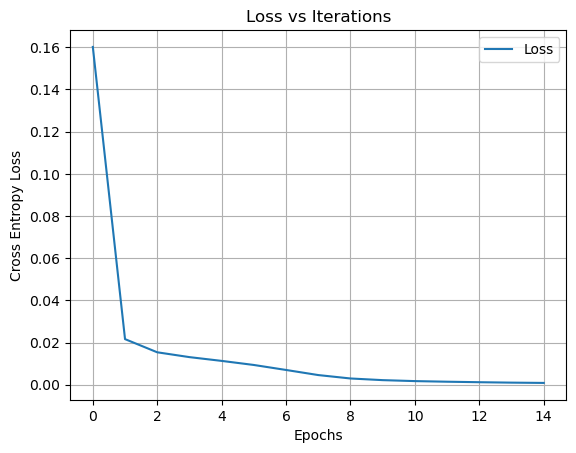

In [90]:
output = LSTM_RNN.forward(dataset)
incorrect = 0
for i in range(output.shape[0]):
    if (output[i].item() - labels[i] > 0.1):
        incorrect += 1
print("Incorrect:", incorrect)

plt.figure()
plt.plot(loss_LSTM, label = 'Loss')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid()
plt.show()

In [91]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.Wzh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wzx = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Wrh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wrx = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Whh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Whx = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.Why = nn.Parameter(torch.randn(output_dim, hidden_dim))

        self.by = nn.Parameter(torch.zeros(output_dim, 1))
        
        self._init_weights()
    
    # initialises the weights of the model
    def _init_weights(self):
        nn.init.xavier_uniform_(self.Wzh)
        nn.init.xavier_uniform_(self.Wzx)
        nn.init.xavier_uniform_(self.Wrh)
        nn.init.xavier_uniform_(self.Wrx)
        nn.init.xavier_uniform_(self.Whh)
        nn.init.xavier_uniform_(self.Whx)
        nn.init.xavier_uniform_(self.Why)

    # forward pass of model
    def forward(self, inputs):
        # expects input as: [list, list, ...]
        ht = torch.zeros(self.hidden_dim, 1)
        output = torch.zeros(len(inputs))

        for i in range(len(inputs)):
            for input in inputs[i]:
                input = torch.tensor(input)
                input = torch.unsqueeze(input, 1)
                
                zt = torch.sigmoid(torch.matmul(self.Wzh, ht) + torch.matmul(self.Wzx, input))
                rt = torch.sigmoid(torch.matmul(self.Wrh, ht) + torch.matmul(self.Wrx, input))
                ht_temp = torch.tanh(torch.matmul(self.Whh, torch.mul(rt, ht)) + torch.matmul(self.Whx, input))

                ht = torch.mul(1 - zt, ht) + torch.mul(zt, ht_temp)

            output[i] = torch.matmul(self.Why, ht) + self.by
        return output
    
    def train(self, dataset, labels, epochs, batch_size = 32):

        self.loss = nn.MSELoss(reduction = 'mean')
        loss_list = []
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.01)
        self.optimizer.zero_grad()
        labels = torch.tensor(labels)

        batches = [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]
        actual = [labels[i:i+batch_size] for i in range(0, len(labels), batch_size)]

        for epoch in range(epochs):
            avg_loss = 0
            for i in range(len(batches)):
                pred = self.forward(batches[i])

                calc_loss = self.loss(actual[i], pred)
                avg_loss += calc_loss.item() * len(batches[i])
                calc_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            loss_list.append(avg_loss/len(dataset))
            print(f"Epoch {epoch}: {avg_loss/len(dataset)}")

        return loss_list
    
torch.manual_seed(0)
GRU_RNN = GRU(2, 7, 1)
loss_GRU = GRU_RNN.train(dataset, labels, 15)

Epoch 0: 0.09376534563302993
Epoch 1: 0.018974681928753852
Epoch 2: 0.00960940875262022
Epoch 3: 0.004963091522082686
Epoch 4: 0.00286349722892046
Epoch 5: 0.001927948771044612
Epoch 6: 0.001429385878285393
Epoch 7: 0.0011123710412532092
Epoch 8: 0.0008589104412589223
Epoch 9: 0.0006554088520351797
Epoch 10: 0.0005278427257668227
Epoch 11: 0.00046127876969985666
Epoch 12: 0.0004276352632790804
Epoch 13: 0.0003722190119558945
Epoch 14: 0.0003267432599328458


Incorrect: 0


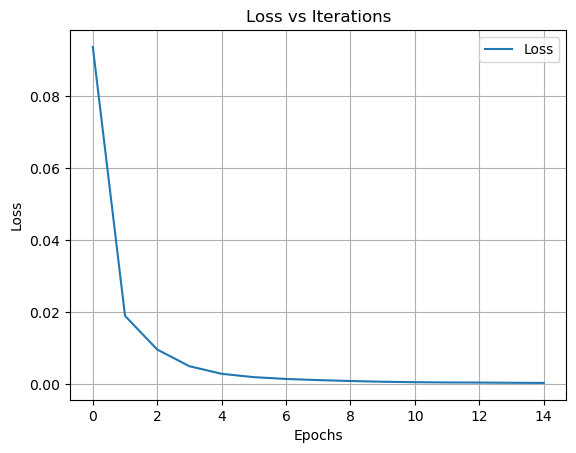

In [92]:
output = GRU_RNN.forward(dataset)
incorrect = 0
for i in range(output.shape[0]):
    if (output[i].item() - labels[i] > 0.1):
        incorrect += 1
print("Incorrect:", incorrect)

plt.figure()
plt.plot(loss_GRU, label = 'Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid()
plt.show()

In [93]:
class Baseline:
    # forward pass of model
    def forward(self, input):
        return torch.ones(len(input))
    
    # calculates loss while training
    def train(self, dataset, labels, epochs, batch_size = 32):

        self.loss = nn.MSELoss(reduction = 'mean')
        loss_list = []
        labels = torch.tensor(labels)

        batches = [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]
        actual = [labels[i:i+batch_size] for i in range(0, len(labels), batch_size)]

        for epoch in range(epochs):
            avg_loss = 0
            for i in range(len(batches)):
                pred = self.forward(batches[i])

                calc_loss = self.loss(actual[i], pred)
                avg_loss += calc_loss.item() * len(batches[i])
                
            loss_list.append(avg_loss/len(dataset))
            print(f"Epoch {epoch}: {avg_loss/len(dataset)}")

        return loss_list

baseline_model = Baseline()
baseline_model.forward(dataset)
loss_baseline = baseline_model.train(dataset, labels, 15)

Epoch 0: 0.16539928302764892
Epoch 1: 0.16539928302764892
Epoch 2: 0.16539928302764892
Epoch 3: 0.16539928302764892
Epoch 4: 0.16539928302764892
Epoch 5: 0.16539928302764892
Epoch 6: 0.16539928302764892
Epoch 7: 0.16539928302764892
Epoch 8: 0.16539928302764892
Epoch 9: 0.16539928302764892
Epoch 10: 0.16539928302764892
Epoch 11: 0.16539928302764892
Epoch 12: 0.16539928302764892
Epoch 13: 0.16539928302764892
Epoch 14: 0.16539928302764892


Comparing the loss of the different models and the baseline model. We have run all the models with a batch size of 32 and a learning rate of 0.01 for a far comparison between the models.

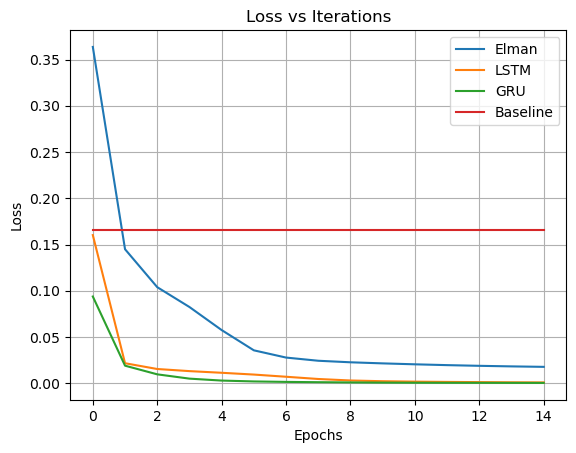

In [94]:
plt.figure()
plt.plot(loss_elman, label = 'Elman')
plt.plot(loss_LSTM, label = 'LSTM')
plt.plot(loss_GRU, label = 'GRU')
plt.plot(loss_baseline, label = 'Baseline')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid()
plt.show()

Losses from:
Elman: 0.01611916348338127
LSTM: 0.0007231315248645842
GRU: 0.00022693218488711864
Baseline: 0.17137233912944794


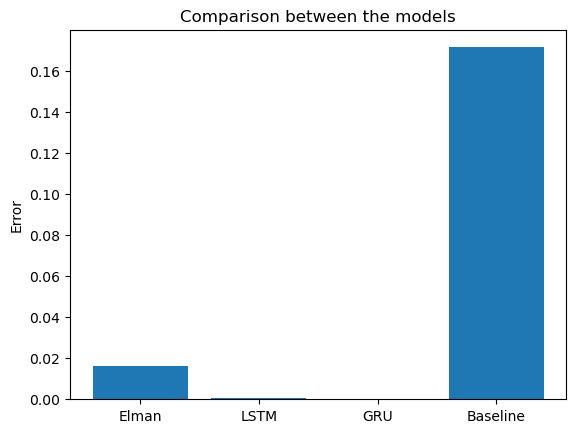

In [95]:
test_dataset, test_labels = create_dataset(7, N = 1500)
elman_test = elmanRNN.forward(test_dataset)
lstm_test = LSTM_RNN.forward(test_dataset)
gru_test = GRU_RNN.forward(test_dataset)
baseline_test = baseline_model.forward(test_dataset)

test_labels = torch.Tensor(test_labels)
loss = nn.MSELoss(reduction='mean')

print("Losses from:")
print("Elman:", loss(test_labels, elman_test).item())
print("LSTM:", loss(test_labels, lstm_test).item())
print("GRU:", loss(test_labels, gru_test).item())
print("Baseline:", loss(test_labels, baseline_test).item())

plt.figure()
plt.bar(["Elman", "LSTM", "GRU", "Baseline"], [loss(test_labels, elman_test).item(), loss(test_labels, lstm_test).item(), loss(test_labels, gru_test).item(), loss(test_labels, baseline_test).item()])
plt.ylabel("Error")
plt.title("Comparison between the models")
plt.show()

As we can see, the performance is as follows: GRU > LSTM > Elman > Baseline